<a href="https://colab.research.google.com/github/muntakson/2dtodepth/blob/master/Copy_of_refactoring_Development_of_immune_index_DC_IM_DEX_V0_2_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 골수유래 수지상 세포 기반 AI 면역능 예측 시스템

## Test file : DC I'MDEX_Version info_0.5

#### in put : CPM data
#### Processing : log CPM
#### AI_model : ML_RandomForestClassifier
#### AI_input : log CPM whole geneoms
#### Result :

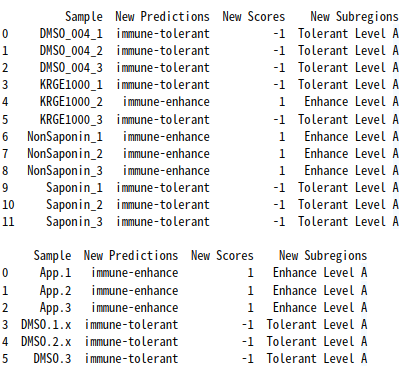


#### 테스트 데이터에서 DMSO가 control로 인식되지 않음 "샘플데이터부족?"아니면 "실제그러한 변화"를보이는가?

In [2]:
pip install pandas numpy scikit-learn matplotlib seaborn tensorflow

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers
from scipy.stats import ttest_ind
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler
from matplotlib.colors import LinearSegmentedColormap


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### 2. 데이터 전처리 (필요 시)
#### 예를 들어, 결측값 처리 또는 정규화
##### data.fillna(0, inplace=True)  # 결측값을 0으로 대체

In [5]:
pwd

'/content'

In [6]:
Raw_dir ="./gdrive/MyDrive/Colab Notebooks/WholMT_IMDCDEX/"  #Data hub

Train_df= pd.read_csv(Raw_dir+"Train_set/ComBat_Train.csv", index_col=0)
#Test_df = pd.read_csv(Raw_dir+"240829_ComBat_Batch_Test_KRGE.csv", index_col=0)

In [ ]:
print(Train_df)

               RGC_P1  RGC_P2  RGC_P3  RGC_L1  RGC_L2  RGC_L3  Spir1  Spir2  \
0610005C13Rik       0       1       0       0       0       0      0      0   
0610009L18Rik      16      13      19      12      17      45      9     18   
0610010K14Rik      64      36     797      56      11    2215     30      9   
0610030E20Rik     968    1241    1567     906    1218    1279    957   1336   
0610031O16Rik       0       0       0       0       0       0      0      0   
...               ...     ...     ...     ...     ...     ...    ...    ...   
Zyg11a              0       0       0       0       1       0      0      2   
Zyg11b            750    1177    1368     740    1068    1094    847   1328   
Zyx             15989   13822   28420   12873   15031   20507  13238  11017   
Zzef1            1718    2594    3106    2211    3016    2512   2562   3152   
Zzz3              973    1248    1744     902    1258    1534    954   1317   

               Spir3  GavL1  ...  GreT.2    LPS  LP

#1. CPM 계산

### - 함수 정의

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, zscore
from statsmodels.stats.multitest import multipletests

# 1. 로그 CPM 데이터로 변환
def log_cpm(data):
    # CPM: Counts Per Million
    cpm = data / data.sum(axis=0) * 1e6
    log_cpm = np.log2(cpm + 1)
    return log_cpm

# 2. p-value 및 adj.P (BH 방식) 계산
def calculate_pvalues(train_data, control_columns):
    # Control과 비교
    control_data = train_data[control_columns]
    sample_data = train_data.drop(columns=control_columns)

    p_values = []
    for gene in train_data.index:
        # T-test (control vs sample)
        t_stat, p_val = ttest_ind(control_data.loc[gene], sample_data.loc[gene], equal_var=False)
        p_values.append(p_val)

    # p_values를 NaN으로 필터링
    p_values = np.array(p_values)
    p_values = pd.Series(p_values, index=train_data.index)

        # 데이터가 없으면 0으로 대체
    p_values.fillna(0, inplace=True)

    # 다중 검정 보정 (Benjamini-Hochberg 방식)
    adj_p_values = multipletests(p_values, method='fdr_bh')[1]

    # adj.P 값과 인덱스를 일치시켜 DataFrame 생성
    pval_data = pd.DataFrame({
        'p_value': p_values,
        'adj_p_value': adj_p_values[:len(p_values)]
    }, index=p_values.index)

    return pval_data

# 3. 유전자 선택 (2FC, adj.P ≤ 0.5)
def select_genes(log_cpm_data, pval_data, control_columns, fold_change_threshold=2, adj_p_threshold=0.05):
    control_mean = log_cpm_data[control_columns].mean(axis=1)
    sample_mean = log_cpm_data.drop(columns=control_columns).mean(axis=1)

    fold_change = sample_mean / control_mean
    selected_genes = (abs(fold_change) >= fold_change_threshold) & (pval_data['adj_p_value'] <= adj_p_threshold)

    return log_cpm_data.loc[selected_genes]

# 4. K-means 클러스터링 및 시각화
def kmeans_clustering(selected_data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(selected_data.T)  # Transpose to cluster samples

    return clusters

# z-score normalization 함수
def zscore_normalization(data):
    return data.apply(zscore, axis=1)

def zscore_relative_to_control(data, control_columns):
    # 컨트롤 데이터의 평균과 표준 편차 계산
    control_mean = data[control_columns].mean(axis=1)
    control_std = data[control_columns].std(axis=1)

    # 각 샘플의 Z-스코어를 컨트롤 그룹 기준으로 계산
    zscored_data = data.apply(lambda x: (x - control_mean) / control_std, axis=0)
     # 데이터가 없으면 0으로 대체
    zscored_data.fillna(0, inplace=True)

    return zscored_data

# 1. 엘보우 메서드 정의
def elbow_method(data, max_k=10):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), inertia, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.show()

# 2. KMeans 클러스터링 함수 정의
def kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans.labels_
# K-means 클러스터링 시각화 개선


def plot_kmeans(selected_data, clusters):

    plt.figure(figsize=(25, 10))

    # 클러스터 색상 매핑
    unique_clusters = np.unique(clusters)
    color_map = {cluster: plt.cm.coolwarm(i / len(unique_clusters)) for i, cluster in enumerate(unique_clusters)}
    cluster_colors = [color_map[cluster] for cluster in clusters]

    # "blue-white-red" 색상 맵 생성
    custom_cmap = LinearSegmentedColormap.from_list("blue_white_red", ["blue", "white", "red"])

    # 클러스터 맵을 생성
    # selected_data의 열을 샘플, 행을 유전자로 설정해야 합니다.
    sns.clustermap(selected_data,
                   row_cluster=True,
                   col_cluster=True,
                   col_colors=cluster_colors,
                   cmap=custom_cmap,  # 사용자 정의 색상 맵 사용
                   figsize=(12, 12),
                   vmin=-2,
                   vmax=2)
    plt.title('K-means Clustering of Genes')
    plt.show()
#dot plot
def plot_dotplot(expression_df, cluster_labels):
    """
    Dot plot of gene expression for clustered genes.

    Parameters:
    - expression_df: (genes x samples) gene expression DataFrame
    - cluster_labels: list or array of cluster labels for each gene (index aligned with expression_df)
    """
    # 클러스터 정보 추가
    df = expression_df.copy()
    df['cluster'] = cluster_labels

    # Melt for seaborn plotting (long-form format)
    df_melted = df.reset_index().melt(id_vars=['index', 'cluster'],
                                      var_name='sample', value_name='expression')
    df_melted.rename(columns={'index': 'gene'}, inplace=True)

    # 시각화
    plt.figure(figsize=(12, 6))
    sns.stripplot(data=df_melted, x='cluster', y='expression', hue='sample', jitter=True, dodge=True, alpha=0.6)
    plt.title("Dot plot of gene expression grouped by cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Expression (Z-score)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
# 엘보우 방법을 사용하여 최적의 클러스터 수 찾기
def elbow_method(data, max_k=10):
    distortions = []
    K = range(1, max_k + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data.T)  # Transpose to cluster samples
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.show()

# PCA 수행 함수
def perform_pca(data):
    pca = PCA(n_components=2)  # 2개의 주성분으로 축소
    principal_components = pca.fit_transform(data.T)  # 샘플을 기준으로 변환
    return principal_components

# PCA 플롯을 생성하는 함수
def plot_pca(principal_components, clusters, sample_names):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='coolwarm', alpha=0.7)
    plt.title('PCA of Samples')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    # 클러스터 레이블 추가
    for i in range(principal_components.shape[0]):
        plt.text(principal_components[i, 0], principal_components[i, 1],
                 sample_names[i], horizontalalignment='left', size='small', color='black', weight='semibold')

    plt.colorbar(scatter, label='Cluster')
    plt.grid()
    plt.show()

In [10]:
control_columns = [col for col in Train_df.columns if 'DMSO' in col]
print(Train_df.head(1))

# 1. Log CPM 데이터 변환
log_cpm_train = log_cpm(Train_df)
print(log_cpm_train.head(10))
len(log_cpm_train.index)


               RGC_P1  RGC_P2  RGC_P3  RGC_L1  RGC_L2  RGC_L3  Spir1  Spir2  \
0610005C13Rik       0       1       0       0       0       0      0      0   

               Spir3  GavL1  ...  GreT.2  LPS  LPS.1  LPS.2  Lute  Lute.1  \
0610005C13Rik      0      0  ...       0    0      0      0     0       0   

               Lute.2  VD3  VD3.1  VD3.2  
0610005C13Rik       0    0      1      0  

[1 rows x 63 columns]
                 RGC_P1    RGC_P2    RGC_P3    RGC_L1    RGC_L2    RGC_L3  \
0610005C13Rik  0.000000  0.073487  0.000000  0.000000  0.000000  0.000000   
0610009L18Rik  0.916411  0.747893  0.741753  0.692419  0.783356  1.224277   
0610010K14Rik  2.185757  1.526692  4.867762  1.954055  0.552489  6.061340   
0610030E20Rik  5.773166  6.041126  5.818629  5.570076  5.718823  5.284773   
0610031O16Rik  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0610038B21Rik  0.353116  0.273847  0.474225  0.547936  0.421539  0.161939   
0610039K10Rik  0.000000  0.334893  0.0

21019

In [11]:
# 2. p-value 및 adj.p_value 계산
pval_data = calculate_pvalues(log_cpm_train, control_columns)
print(pval_data)

                    p_value   adj_p_value
0610005C13Rik  4.116790e-01  5.212071e-01
0610009L18Rik  2.593267e-01  3.709373e-01
0610010K14Rik  1.024513e-06  6.808170e-06
0610030E20Rik  4.405000e-05  1.992869e-04
0610031O16Rik  0.000000e+00  0.000000e+00
...                     ...           ...
Zyg11a         7.059657e-01  7.848253e-01
Zyg11b         4.998926e-03  1.347946e-02
Zyx            1.057411e-08  1.062924e-07
Zzef1          1.530051e-01  2.448803e-01
Zzz3           6.030110e-02  1.133085e-01

[21019 rows x 2 columns]


In [13]:
# 3. 유전자 선택
selected_genes_data = select_genes(log_cpm_train, pval_data, control_columns)
print(selected_genes_data)
len(selected_genes_data.index)

                 RGC_P1    RGC_P2    RGC_P3    RGC_L1    RGC_L2    RGC_L3  \
0610043K17Rik  0.077876  0.073487  0.050159  0.442893  0.593624  0.272479   
1110032F04Rik  1.735288  1.722159  0.741753  2.732612  2.480600  2.575184   
1600002D24Rik  0.000000  0.000000  0.050159  0.206640  0.059936  0.161939   
1600014C23Rik  0.000000  0.000000  0.000000  0.072219  0.172818  0.042220   
1700010B08Rik  0.000000  0.000000  0.000000  0.000000  0.059936  0.000000   
...                 ...       ...       ...       ...       ...       ...   
Zp1            0.077876  0.073487  0.000000  0.000000  0.059936  0.042220   
Zp2            0.000000  0.073487  0.000000  0.000000  0.000000  0.000000   
Zp3r           0.000000  0.000000  0.000000  0.000000  0.059936  0.000000   
Zscan4d        0.000000  0.000000  0.000000  0.000000  0.059936  0.000000   
Zscan5b        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                  Spir1     Spir2     Spir3     GavL1  ...    GreT.2  \
061

1241

In [14]:
# z-score normalization
zscore_data = zscore_normalization(selected_genes_data)
print(zscore_data)

0610043K17Rik    [-0.8016973183897278, -0.8241131689478838, -0....
1110032F04Rik    [0.1879036590693286, 0.16971425882765462, -1.1...
1600002D24Rik    [-1.1271561669929835, -1.1271561669929835, -0....
1600014C23Rik    [-0.6155681042659229, -0.6155681042659229, -0....
1700010B08Rik    [-0.41242077082069245, -0.41242077082069245, -...
                                       ...                        
Zp1              [1.6674576630330855, 1.5553443212490825, -0.32...
Zp2              [-0.33444464910436855, 1.6832214804657248, -0....
Zp3r             [-0.29703989189958135, -0.29703989189958135, -...
Zscan4d          [-0.31096874605088964, -0.31096874605088964, -...
Zscan5b          [-0.3298595937538765, -0.3298595937538765, -0....
Length: 1241, dtype: object


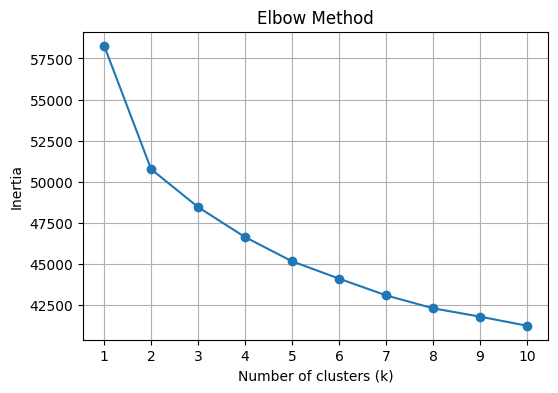

In [16]:
zscore_df = selected_genes_data.apply(
    lambda row: zscore(row, nan_policy='omit'),
    axis=1,                  # 각 gene(행)별
    result_type='expand'     # DataFrame으로 펼쳐줌
)
zscore_df.index = selected_genes_data.index      # gene 이름 복구
zscore_df.columns = selected_genes_data.columns  # sample 이름 복구

data_for_kmeans = zscore_df      # gene clustering 예시

def elbow_method(df, k_max=10):
    inertias = []
    for k in range(1, k_max + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        km.fit(df.values)        # DataFrame → numpy 2-D
        inertias.append(km.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, k_max + 1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.xticks(range(1, k_max + 1))
    plt.grid(True)
    plt.show()

elbow_method(data_for_kmeans, k_max=10)

In [17]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(data_for_kmeans.values)
zscore_df['cluster'] = clusters        # gene별 클러스터 레이블 부여

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2500x1000 with 0 Axes>

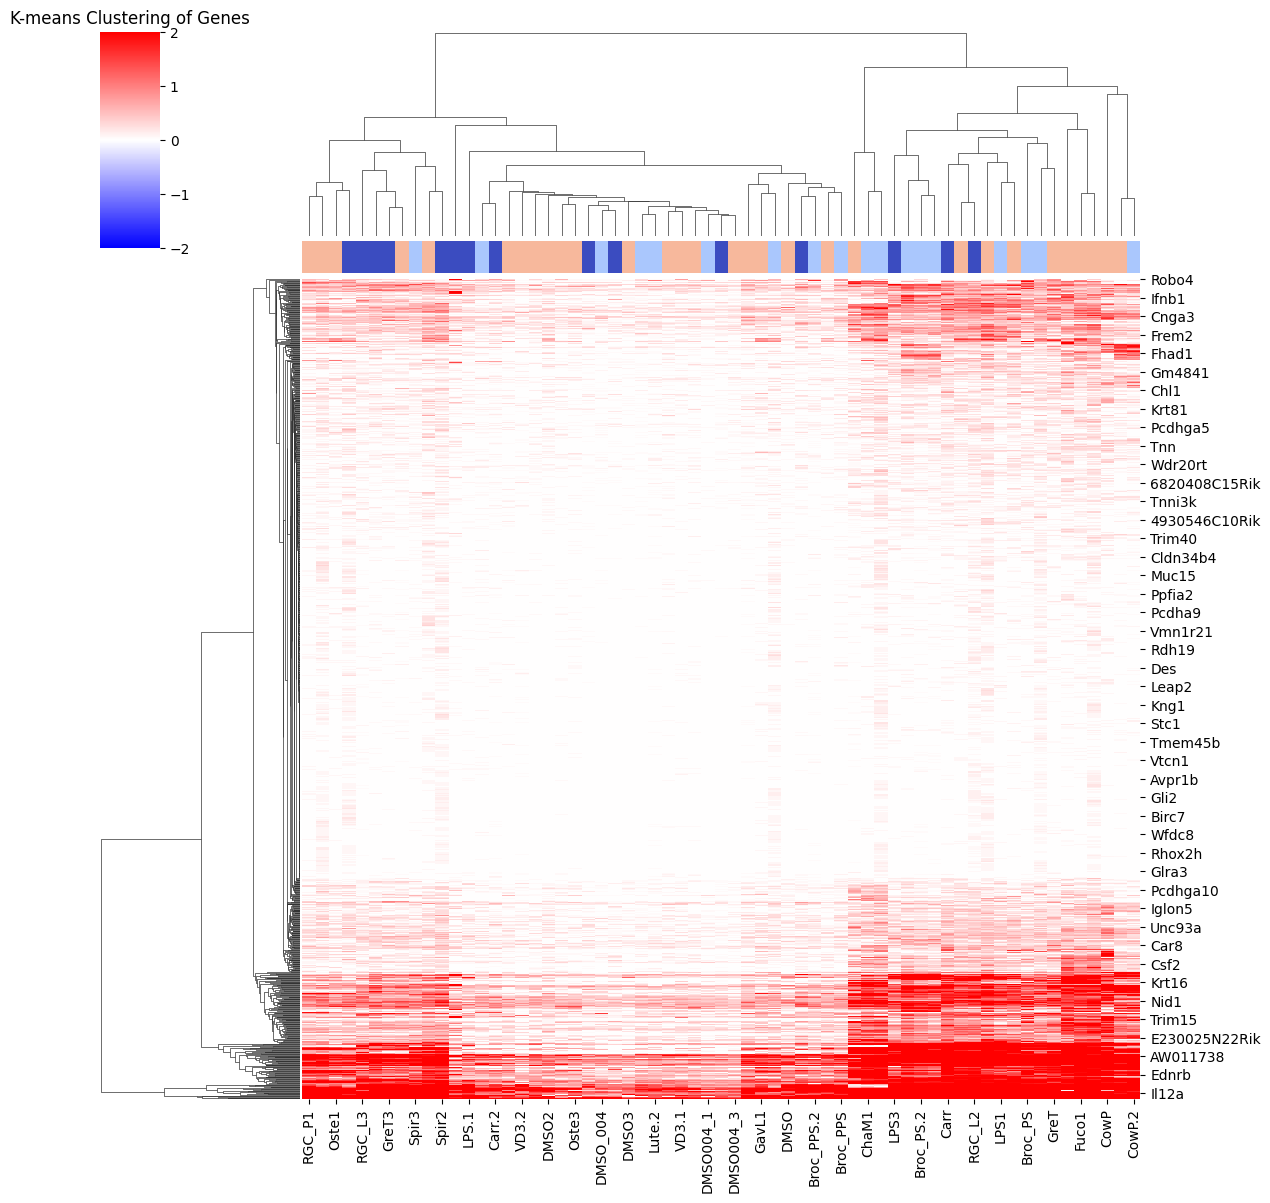

In [19]:
# 5. 클러스터 결과를 시각화
n_clusters = 3  # 클러스터 수 설정
plot_kmeans(selected_genes_data, clusters)


/tmp/ipython-input-7-1352294161.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


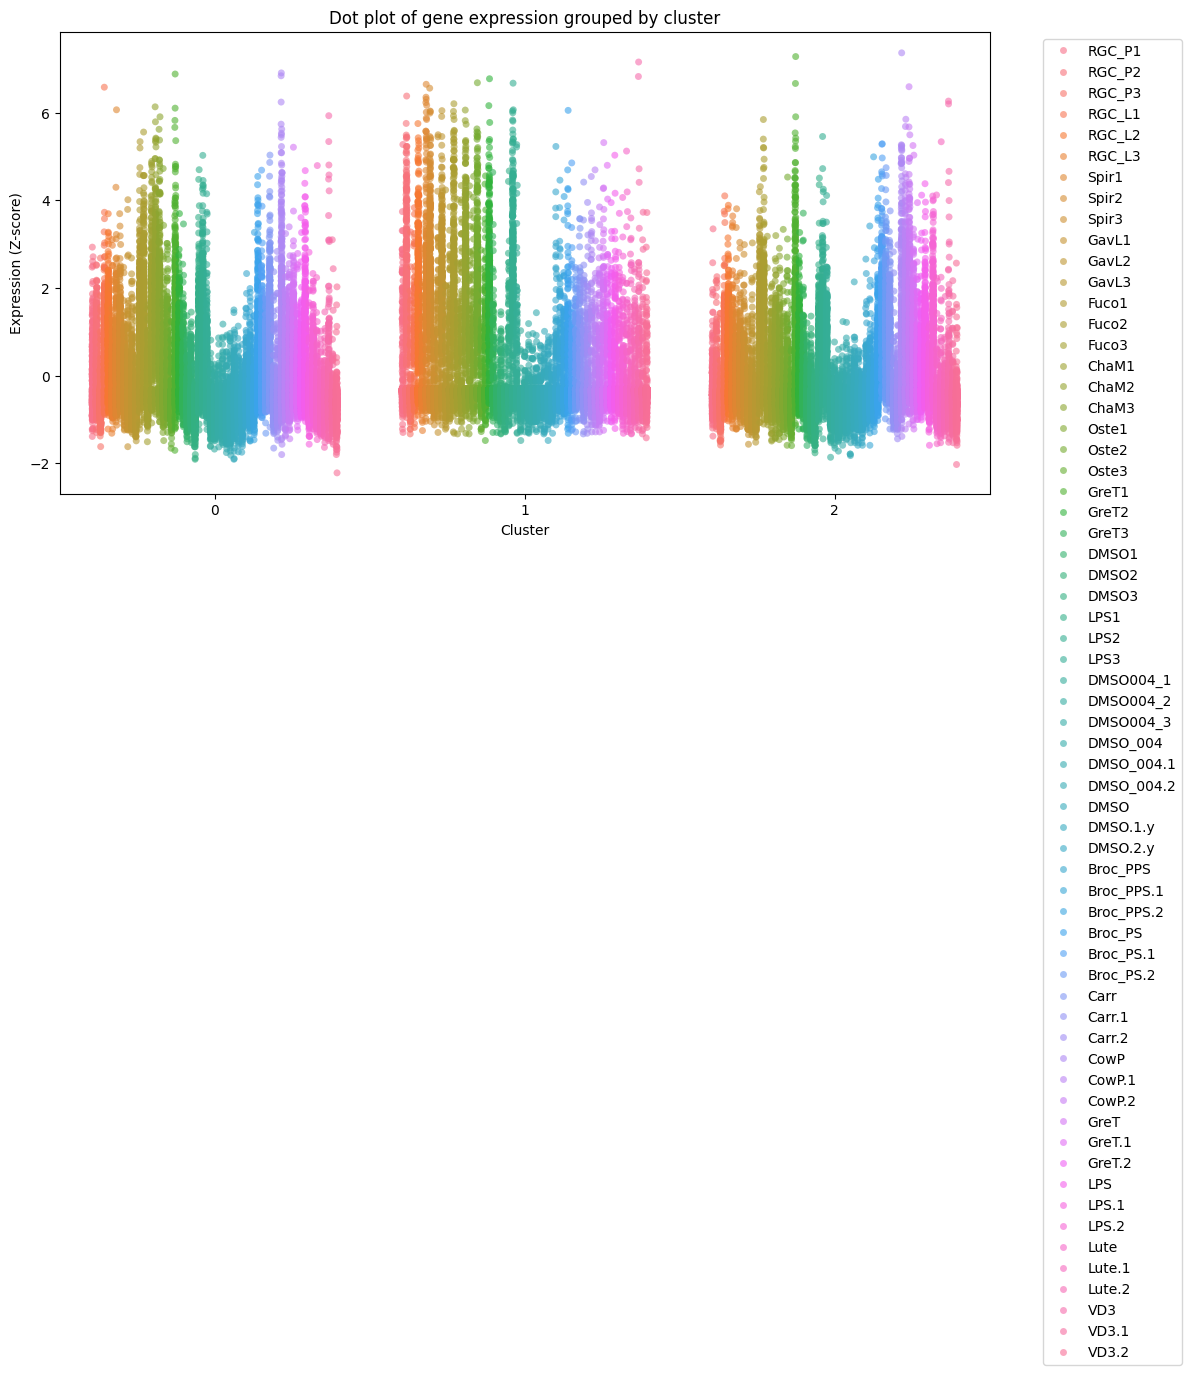

In [20]:
# 도트 플롯 시각화
plot_dotplot(zscore_df.drop(columns='cluster'), zscore_df['cluster'])

In [31]:
def perform_pca(expression_df, n_components=2):
    """
    expression_df: genes × samples DataFrame (Z-score normalized)
    """
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(expression_df.values)
    return pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(n_components)],
                        index=expression_df.index)

def plot_pca(pca_df, clusters, labels=None):
    """
    pca_df: PCA 결과 DataFrame (rows = genes)
    clusters: clustering labels (gene 기준)
    labels: optional, sample names (not used if genes clustered)
    """
    df_plot = pca_df.copy()
    df_plot['cluster'] = clusters

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='cluster', palette='Set2', s=60)
    plt.title('PCA of Gene Expression (Clustered Genes)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

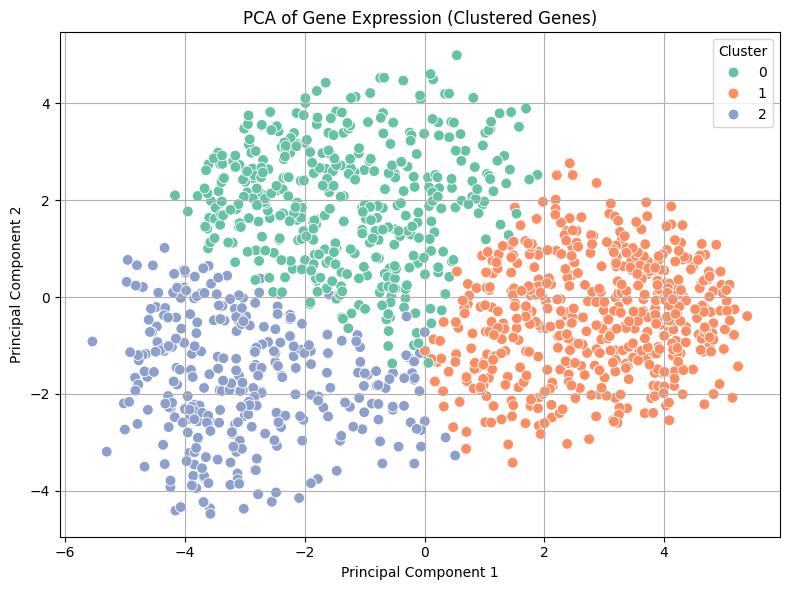

In [47]:
# 전처리 완료된 zscore_df 사용 (genes × samples)
pca_result = perform_pca(zscore_df)
plot_pca(pca_result, zscore_df['cluster'])

In [30]:
from sklearn.cluster import KMeans

# Sample 기준 클러스터링
n_clusters = 3  # 적절한 클러스터 수로 조정
sample_data = zscore_df.T  # 샘플 × 유전자
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sample_clusters = kmeans.fit_predict(sample_data)

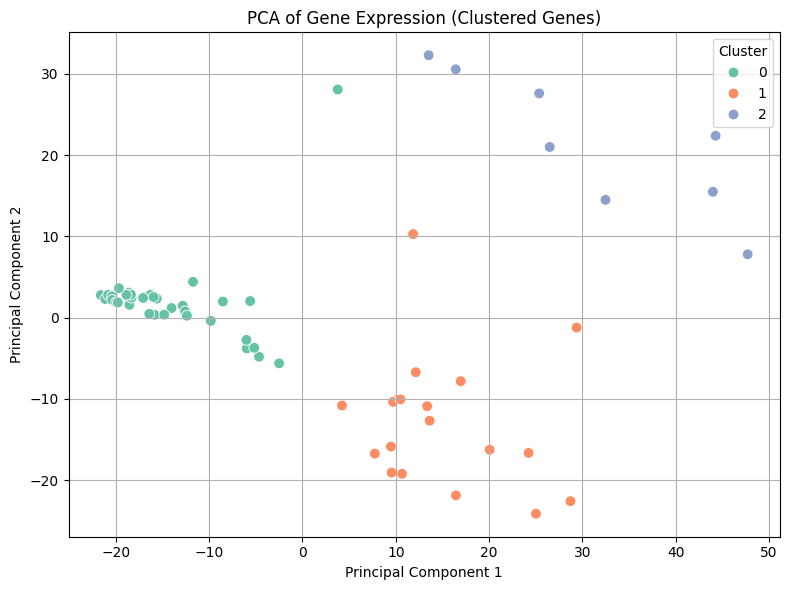

In [46]:
pca_result_samples = perform_pca(sample_data)
plot_pca(pca_result_samples, sample_clusters, labels=sample_data.index)

In [38]:
import plotly.express as px
import pandas as pd

def plot_pca_interactive(pca_df, clusters, gene_names=None):
    """
    Interactive PCA plot for clustered data (e.g., samples or genes).

    Parameters:
    - pca_df: DataFrame with columns ['PC1', 'PC2'], index = sample or gene names
    - clusters: array-like of cluster labels
    - gene_names: optional list or index (used as hover names)
    """
    df_plot = pca_df.copy()
    df_plot['Cluster'] = clusters
    if gene_names is not None:
        df_plot['Name'] = gene_names
    else:
        df_plot['Name'] = df_plot.index

    fig = px.scatter(
        df_plot, x='PC1', y='PC2', color='Cluster',
        hover_name='Name', title='Interactive PCA Plot',
        color_discrete_sequence=px.colors.qualitative.Set2
    )
    fig.update_traces(marker=dict(size=8, line=dict(width=0.5, color='DarkSlateGrey')))
    fig.update_layout(template='plotly_white')
    fig.show()


In [40]:
plot_pca_interactive(pca_result_samples, sample_clusters, gene_names=sample_data.index)

In [44]:
def plot_pca_with_labels(pca_df, clusters, gene_names):
    df_plot = pca_df.copy()
    df_plot['cluster'] = clusters
    df_plot['gene'] = gene_names

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='cluster', palette='Set2', s=60)

    # 유전자 이름 추가
    for i in range(len(df_plot)):
        plt.text(df_plot['PC1'][i], df_plot['PC2'][i], df_plot['gene'][i], fontsize=8, alpha=0.7)

    plt.title('PCA of Gene Expression with Gene Names')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [42]:
import plotly.express as px

def plot_pca_interactive(pca_df, clusters, gene_names):
    df_plot = pca_df.copy()
    df_plot['cluster'] = clusters
    df_plot['gene'] = gene_names

    fig = px.scatter(
        df_plot, x='PC1', y='PC2', color='cluster',
        hover_name='gene',
        title='Interactive PCA Plot of Genes',
        width=800, height=600
    )
    fig.update_traces(marker=dict(size=8, opacity=0.8))
    fig.show()

In [48]:
plot_pca_interactive(pca_result, zscore_df['cluster'], gene_names=zscore_df.index)

이 결과를 이용해서 PCA 상에 좌측과 우측에 존재하는 샘플들을 DSMO 기준으로 분류하는 머신러닝 모델 생성.

In [49]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [50]:
#Train_logCPM_immuneDEX= pd.read_csv(Raw_dir+"Train_set/logCPM_data.csv", index_col=0)
Train_logCPM_immuneDEX= selected_genes_data
len(Train_logCPM_immuneDEX.columns)

#Train_zscoers_immuneDEX = zscore_normalization(Train_logCPM_immuneDEX)

#Train_zscoers_immuneDEX = Train_zscoers_immuneDEX.fillna(0, inplace=True)

#len(Train_zscoers_immuneDEX.index)

63

In [51]:
Train_logCPM_immuneDEX.columns
print(Train_logCPM_immuneDEX.head)

#Train_zscoers_immuneDEX.columns
#print(Train_zscoers_immuneDEX.head)

<bound method NDFrame.head of                  RGC_P1    RGC_P2    RGC_P3    RGC_L1    RGC_L2    RGC_L3  \
0610043K17Rik  0.077876  0.073487  0.050159  0.442893  0.593624  0.272479   
1110032F04Rik  1.735288  1.722159  0.741753  2.732612  2.480600  2.575184   
1600002D24Rik  0.000000  0.000000  0.050159  0.206640  0.059936  0.161939   
1600014C23Rik  0.000000  0.000000  0.000000  0.072219  0.172818  0.042220   
1700010B08Rik  0.000000  0.000000  0.000000  0.000000  0.059936  0.000000   
...                 ...       ...       ...       ...       ...       ...   
Zp1            0.077876  0.073487  0.000000  0.000000  0.059936  0.042220   
Zp2            0.000000  0.073487  0.000000  0.000000  0.000000  0.000000   
Zp3r           0.000000  0.000000  0.000000  0.000000  0.059936  0.000000   
Zscan4d        0.000000  0.000000  0.000000  0.000000  0.059936  0.000000   
Zscan5b        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                  Spir1     Spir2     Spir3  

In [53]:
labels = ['control'] * 12 + ['immune-enhance'] * 30 + ['immune-tolerant'] * 21  # 30개 강화, 12개 억제, 12개 제어
labels = pd.Series(labels)  # pandas Series로 변환

features = Train_logCPM_immuneDEX.T
#features = Train_zscoers_immuneDEX.T

In [ ]:
print(features)

        0610043K17Rik  1110032F04Rik  1600002D24Rik  1600014C23Rik  \
RGC_P1       0.077876       1.735288       0.000000       0.000000   
RGC_P2       0.073487       1.722159       0.000000       0.000000   
RGC_P3       0.050159       0.741753       0.050159       0.000000   
RGC_L1       0.442893       2.732612       0.206640       0.072219   
RGC_L2       0.593624       2.480600       0.059936       0.172818   
...               ...            ...            ...            ...   
Lute.1       0.146942       0.684891       0.192775       0.146942   
Lute.2       0.211483       0.961452       0.044850       0.000000   
VD3          0.161622       0.932693       0.055910       0.211708   
VD3.1        0.148093       0.623416       0.148093       0.000000   
VD3.2        0.248672       1.024760       0.000000       0.000000   

        1700010B08Rik  1700012B09Rik  1700012D01Rik  1700017G19Rik  \
RGC_P1       0.000000       0.636574       0.353116            0.0   
RGC_P2       0.0000

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

# Random Forest 분류기 생성 및 훈련
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# 테스트 세트에서 예측
y_pred = rf_classifier.predict(X_test)

In [55]:
#모델 성능 테스트
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                 precision    recall  f1-score   support

        control       0.00      0.00      0.00         2
 immune-enhance       0.33      1.00      0.50         2
immune-tolerant       1.00      0.33      0.50         3

       accuracy                           0.43         7
      macro avg       0.44      0.44      0.33         7
   weighted avg       0.52      0.43      0.36         7

[[0 2 0]
 [0 2 0]
 [0 2 1]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-p

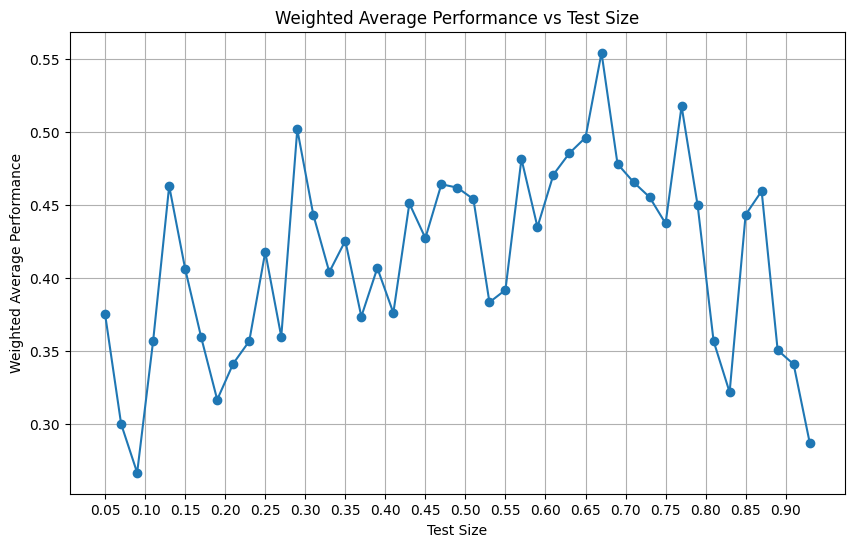

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# test_size 값 범위 설정
test_sizes = np.arange(0.05, 0.95, 0.02)
weighted_avg_performance = []

for test_size in test_sizes:
    # 데이터 훈련 및 테스트 세트로 분할
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)

    # Random Forest 분류기 생성 및 훈련
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # 테스트 세트에서 예측
    y_pred = rf_classifier.predict(X_test)

    # 모델 성능 테스트
    report = classification_report(y_test, y_pred, output_dict=True)
    weighted_avg = report['weighted avg']['f1-score']  # Weighted Average Performance 저장
    weighted_avg_performance.append(weighted_avg)

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame({
    'test_size': test_sizes,
    'weighted_avg_performance': weighted_avg_performance
})

# X, Y 차트 그리기
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['test_size'], results_df['weighted_avg_performance'], marker='o')
plt.title('Weighted Average Performance vs Test Size')
plt.xlabel('Test Size')
plt.ylabel('Weighted Average Performance')
plt.grid()
plt.xticks(np.arange(0.05, 0.95, 0.05))
plt.show()




In [57]:
#최적성능 검증
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)


Fitting 3 folds for each of 294 candidates, totalling 882 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [58]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=2, min_samples_split=4, random_state=42)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.27, random_state=42)

# Random Forest 분류기 생성 및 훈련
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# 테스트 세트에서 예측
y_pred = rf_classifier.predict(X_test)

#모델 성능 테스트
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

                 precision    recall  f1-score   support

        control       0.00      0.00      0.00         4
 immune-enhance       0.38      0.62      0.48         8
immune-tolerant       0.67      0.33      0.44         6

       accuracy                           0.39        18
      macro avg       0.35      0.32      0.31        18
   weighted avg       0.39      0.39      0.36        18

[[0 4 0]
 [2 5 1]
 [0 4 2]]


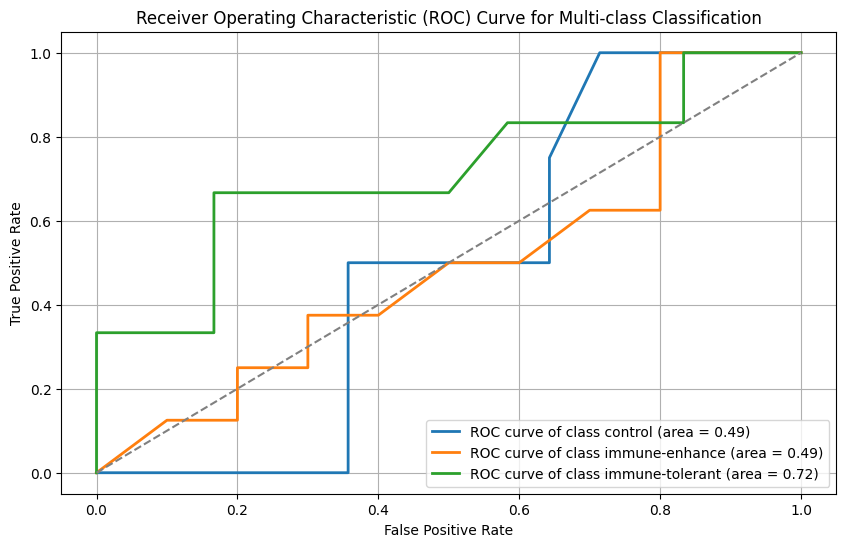

Macro-average AUC: 0.57


In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# 예측 확률 계산 (각 클래스에 대한 확률) 이진 분류 . Samples vs others
y_pred_proba = rf_classifier.predict_proba(X_test)

# 레이블 이진화 (One-vs-Rest 방식)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)  # 각 클래스를 이진화 (One-vs-Rest 방식)

# 각 클래스에 대해 ROC 곡선 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):  # 각 클래스에 대해 반복
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 시각화
plt.figure(figsize=(10, 6))

for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {lb.classes_[i]} (area = {roc_auc[i]:0.2f})')

# 대각선 (무작위 분류 기준선)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 평균 AUC (Macro-average)
macro_auc = sum(roc_auc.values()) / len(roc_auc)
print(f'Macro-average AUC: {macro_auc:.2f}')

In [62]:
# 유전자 중요도 추출
feature_importance = rf_classifier.feature_importances_

# 중요도를 DataFrame으로 변환하여 유전자 이름과 함께 확인
importance_df = pd.DataFrame({
    'feature': features.columns,
    'importance': feature_importance
})

# 중요도 내림차순으로 정렬
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 상위 n개의 유전자 출력
display(importance_df.head(500))

,feature,importance
539,Hes7,0.023223
663,Lmtk3,0.013818
854,Pdlim3,0.013542
951,Rspo2,0.012234
668,Lrp2bp,0.011987
...,...,...
194,Ccdc103,0.000314
974,Serp2,0.000312
113,Apol9b,0.000213
1114,Tnfsf18,0.000156


<ipython-input-48-428276619>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




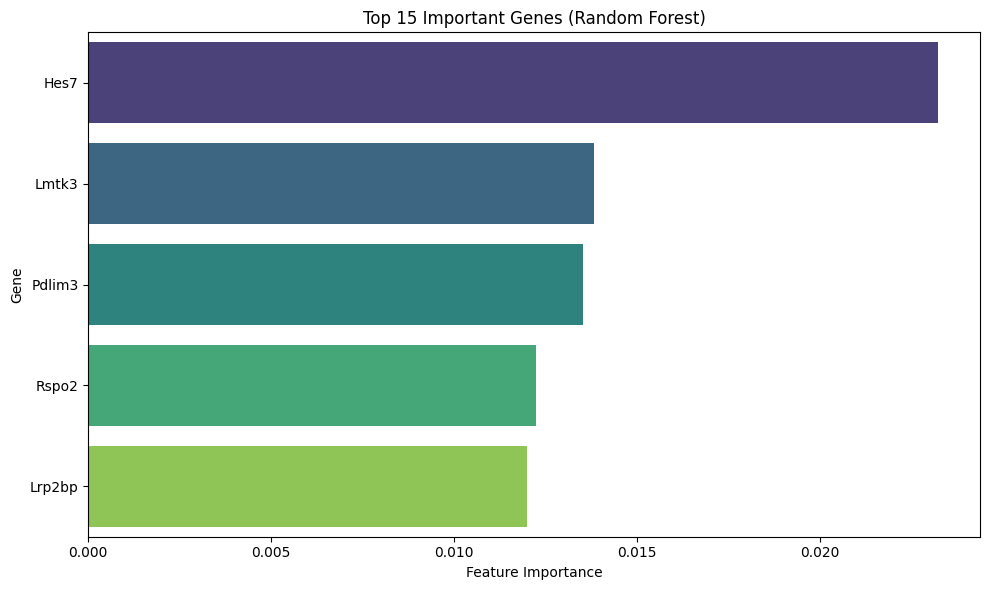

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top5_df = importance_df.head(5)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    x='importance',
    y='feature',
    data=top5_df,
    palette='viridis'
)
plt.title('Top 15 Important Genes (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()

In [63]:
log_cpm_train

,RGC_P1,RGC_P2,RGC_P3,RGC_L1,RGC_L2,RGC_L3,Spir1,Spir2,Spir3,GavL1,...,GreT.2,LPS,LPS.1,LPS.2,Lute,Lute.1,Lute.2,VD3,VD3.1,VD3.2
0610005C13Rik,0.000000,0.073487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051072,0.000000
0610009L18Rik,0.916411,0.747893,0.741753,0.692419,0.783356,1.224277,0.583500,0.941494,0.553574,0.703636,...,0.845166,0.980732,0.618155,1.018660,0.870149,0.921056,0.961452,1.153775,1.106420,1.046821
0610010K14Rik,2.185757,1.526692,4.867762,1.954055,0.552489,6.061340,1.412294,0.546223,3.861003,3.622329,...,5.221131,3.018404,3.415030,3.189089,5.496722,5.166635,5.781210,4.197465,5.203765,5.493448
0610030E20Rik,5.773166,6.041126,5.818629,5.570076,5.718823,5.284773,5.755022,6.115257,5.911684,5.831516,...,5.805444,5.630206,5.973163,5.728865,5.587833,5.954388,5.904968,5.864351,5.841925,6.140992
0610031O16Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyg11a,0.000000,0.000000,0.000000,0.000000,0.059936,0.000000,0.000000,0.140490,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Zyg11b,5.412697,5.965928,5.626405,5.284887,5.533062,5.065615,5.582330,6.106717,5.734729,5.776051,...,5.424159,5.313188,5.764911,5.160597,5.481951,5.756861,5.502463,5.603332,5.492951,5.573515
Zyx,9.794096,9.498436,9.975101,9.370259,9.318782,9.252677,9.520046,9.140592,8.753665,9.899532,...,8.739609,9.171085,9.587805,8.480276,10.653456,10.392627,10.311321,9.138955,10.343548,10.209505
Zzef1,6.589254,7.093328,6.792960,6.839156,7.010521,6.240313,7.158868,7.341564,7.247032,6.322774,...,6.692201,7.111228,7.363881,6.641710,7.006536,7.099440,6.892496,7.171937,6.759516,6.725335


In [64]:
# 모델 예측 결과 분석 (예시로 클래스별 F1-score)
report = classification_report(y_test, y_pred, output_dict=True)

# F1-score 확인 (weighted avg 포함)
print("F1-score (weighted avg):", report['weighted avg']['f1-score'])

# 클래스별 F1-score 출력
for class_name in report:
    if class_name != 'accuracy' and class_name != 'weighted avg':
        print(f"Class: {class_name}, F1-score: {report[class_name]['f1-score']}")

F1-score (weighted avg): 0.35978835978835977
Class: control, F1-score: 0.0
Class: immune-enhance, F1-score: 0.47619047619047616
Class: immune-tolerant, F1-score: 0.4444444444444444
Class: macro avg, F1-score: 0.30687830687830686


In [65]:
# 각 그룹 점수 매기기
def score_groups(predictions):
    score_mapping = {
        'immune-enhance': 1,
        'immune-tolerant': -1,
        'control': 0
    }
    scores = [score_mapping.get(pred, -1) for pred in predictions]
    return scores

# 테스트 예측에 점수 매기기
scores = score_groups(y_pred)
print(scores)

[1, 1, 1, -1, 1, 1, 0, -1, 1, 1, 1, 1, 1, 0, 1, -1, 1, 1]


In [ ]:
def classify_into_subregions(scores):
    subregions = []
    for score in scores:
        if score == 1:  # 면역 강화
            subregions.append('Enhance Level A')
        elif score == -1:  # 면역 억제
            subregions.append('Tolerant Level A')
        else:  # 제어 샘플
            subregions.append('Control')
    return subregions

# 서브리전으로 분류
subregions = classify_into_subregions(scores)


In [ ]:
subregions


['Enhance Level A',
 'Enhance Level A',
 'Enhance Level A',
 'Tolerant Level A',
 'Enhance Level A',
 'Enhance Level A',
 'Control',
 'Tolerant Level A',
 'Enhance Level A',
 'Enhance Level A',
 'Enhance Level A',
 'Enhance Level A',
 'Enhance Level A',
 'Control',
 'Enhance Level A',
 'Tolerant Level A',
 'Enhance Level A',
 'Enhance Level A']

In [ ]:
# 결과를 보여주기 위한 DataFrame 생성
results = pd.DataFrame({
    'Sample': X_test.index,  # 테스트 샘플 이름 추가
    'Predictions': y_pred,
    'Scores': scores,
    'Subregions': subregions
})
print(results)

        Sample      Predictions  Scores        Subregions
0        VD3.1   immune-enhance       1   Enhance Level A
1         Lute   immune-enhance       1   Enhance Level A
2       RGC_P1   immune-enhance       1   Enhance Level A
3    Broc_PS.1  immune-tolerant      -1  Tolerant Level A
4       RGC_L3   immune-enhance       1   Enhance Level A
5         DMSO   immune-enhance       1   Enhance Level A
6        ChaM2          control       0           Control
7        Fuco1  immune-tolerant      -1  Tolerant Level A
8        DMSO2   immune-enhance       1   Enhance Level A
9          VD3   immune-enhance       1   Enhance Level A
10       LPS.1   immune-enhance       1   Enhance Level A
11       GavL1   immune-enhance       1   Enhance Level A
12  Broc_PPS.1   immune-enhance       1   Enhance Level A
13       Fuco2          control       0           Control
14  DMSO_004.1   immune-enhance       1   Enhance Level A
15      CowP.1  immune-tolerant      -1  Tolerant Level A
16      RGC_L1

In [66]:
def classify_new_data(new_data):
    new_predictions = rf_classifier.predict(new_data)
    new_scores = score_groups(new_predictions)
    new_subregions = classify_into_subregions(new_scores)

    return new_predictions, new_scores, new_subregions

In [72]:
def classify_into_subregions(scores):
    subregions = []
    for score in scores:
        if score == 1:  # 면역 강화
            subregions.append('Enhance Level A')
        elif score == -1:  # 면역 억제
            subregions.append('Tolerant Level A')
        else:  # 제어 샘플
            subregions.append('Control')
    return subregions

In [73]:
# 예: 기존 features에서 일부 샘플 선택
new_data = features.loc[['DMSO', 'VD3.1', 'Fuco1']]  # 존재하는 샘플 이름 사용

new_predictions, new_scores, new_subregions = classify_new_data(new_data)

# 결과 보기
for i in range(len(new_data)):
    print(f"Sample: {new_data.index[i]}, Prediction: {new_predictions[i]}, Score: {new_scores[i]}, Subregion: {new_subregions[i]}")


Sample: DMSO, Prediction: immune-enhance, Score: 1, Subregion: Enhance Level A
Sample: VD3.1, Prediction: immune-enhance, Score: 1, Subregion: Enhance Level A
Sample: Fuco1, Prediction: immune-tolerant, Score: -1, Subregion: Tolerant Level A


In [74]:
new_predictions, new_scores, new_subregions = classify_new_data(new_data)

In [75]:
def classify_into_subregions(scores):
    subregions = []
    for score in scores:
        if score == 1:  # 면역 강화
            subregions.append('Enhance Level A')
        elif score == -1:  # 면역 억제
            subregions.append('Tolerant Level A')
        else:  # 제어 샘플
            subregions.append('Control')
    return subregions


In [79]:
Train_df
control_test = [col for col in Train_df.columns if 'DMSO' in col]


# 1. Log CPM 데이터 변환
log_cpm_test = log_cpm(Train_df)
#print(log_cpm_test.head(10))
#len(log_cpm_test.index)

new_data = log_cpm_test # 새로운 데이터 로드
new_data = new_data.T  # 새로운 데이터도 샘플(열) 기준으로 전치
new_data_aligned = new_data.reindex(columns=features.columns, fill_value=0)
new_predictions, new_scores, new_subregions = classify_new_data(new_data_aligned)


# 새로운 데이터 분류 결과 표시
new_results = pd.DataFrame({
    'Sample': new_data.index,          # 샘플 이름을 'Sample' 컬럼으로 추가
    'New Predictions': new_predictions,
    'New Scores': new_scores,
    'New Subregions': new_subregions
})


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

new_results

,Sample,New Predictions,New Scores,New Subregions
0,RGC_P1,immune-enhance,1,Enhance Level A
1,RGC_P2,control,0,Control
2,RGC_P3,control,0,Control
3,RGC_L1,immune-enhance,1,Enhance Level A
4,RGC_L2,control,0,Control
5,RGC_L3,immune-enhance,1,Enhance Level A
6,Spir1,control,0,Control
7,Spir2,control,0,Control
8,Spir3,control,0,Control
9,GavL1,immune-enhance,1,Enhance Level A


In [3]:
print("Predicted Immune Scores for New Samples:")
predicted_results = pd.DataFrame({
    'Sample': new_data.index,  # 샘플 이름
    'Predicted Immune Score': new_scores,
    'Predicted Label': new_predictions,
    'Predicted Subregion': new_subregions
})

print(predicted_results)

Predicted Immune Scores for New Samples:


NameError: name 'pd' is not defined

In [2]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=new_results)

NameError: name 'new_results' is not defined

In [ ]:
def classify_new_data(new_data):
    # 새로운 데이터에 대한 예측 수행
    new_predictions = rf_classifier.predict(new_data)
    new_scores = score_groups(new_predictions)

    # 점수를 기반으로 하위 지역 분류 ## 업데이트 예정
    new_subregions = classify_into_subregions(new_scores)

    # 면역 수준 분류 (각각의 샘플에 대해 점수 또는 예측 결과를 기반으로)
    # 예: classify_immune_levels는 점수 또는 예측값을 인자로 받도록 가정
    final_new_predictions = [classify_immune_levels(score) for score in new_scores]

    return new_predictions, new_scores, new_subregions, final_new_predictions


In [83]:
len(Test_df.index)

NameError: name 'Test_df' is not defined

In [82]:
Test_df

control_test = [col for col in Test_df.columns if 'DMSO' in col]
# 1. Log CPM 데이터 변환
log_cpm_test = log_cpm(Test_df)

len(log_cpm_test.columns)
print(log_cpm_test.head(10))
len(log_cpm_test.index)

#test_zscoers_immuneDEX = zscore_normalization(log_cpm_test)

#test_zscoers_immuneDEX = test_zscoers_immuneDEX.dropna()

#len(test_zscoers_immuneDEX.columns)
#print(test_zscoers_immuneDEX.head(10))
#len(test_zscoers_immuneDEX.index)

NameError: name 'Test_df' is not defined

In [1]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=new_results)

NameError: name 'new_results' is not defined

In [ ]:
Test_df

control_test = [col for col in Test_df.columns if 'DMSO' in col]
# 1. Log CPM 데이터 변환
log_cpm_test = log_cpm(Test_df)

len(log_cpm_test.columns)
print(log_cpm_test.head(10))
len(log_cpm_test.index)

#test_zscoers_immuneDEX = zscore_normalization(log_cpm_test)

#test_zscoers_immuneDEX = test_zscoers_immuneDEX.dropna()

#len(test_zscoers_immuneDEX.columns)
#print(test_zscoers_immuneDEX.head(10))
#len(test_zscoers_immuneDEX.index)

               DMSO_004_1  DMSO_004_2  DMSO_004_3  KRGE1000_1  KRGE1000_2  \
0610005C13Rik    0.000000    0.000000    0.000000    0.000000    0.050237   
0610009L18Rik    1.134865    0.775388    0.589468    0.923134    0.680230   
0610010K14Rik    1.713624    1.631975    1.938866    2.736073    2.392922   
0610030E20Rik    5.578719    5.635537    5.672520    5.753793    5.668376   
0610031O16Rik    0.000000    0.000000    0.000000    0.000000    0.000000   
0610038B21Rik    0.534552    0.583187    0.589468    0.493009    0.474862   
0610039K10Rik    0.000000    0.000000    0.000000    0.057607    0.000000   
0610040B10Rik    1.134865    1.072489    0.797118    0.493009    1.019784   
0610040F04Rik    0.774092    0.400803    0.208255    0.315481    0.399352   
0610040J01Rik    0.377396    0.617052    0.255939    0.534176    0.360061   

               KRGE1000_3  NonSaponin_1  NonSaponin_2  NonSaponin_3  \
0610005C13Rik    0.000000      0.000000      0.000000      0.059668   
0610009L18

21019

In [ ]:
new_data = log_cpm_test # 새로운 데이터 로드
new_data = new_data.T  # 새로운 데이터도 샘플(열) 기준으로 전치
new_results = classify_new_data(new_data)
new_predictions, new_scores, new_subregions = classify_new_data(new_data)
# 결과 출력
print(new_results)


# 새로운 데이터 분류 결과 표시
new_results = pd.DataFrame({
    'Sample': new_data.index,          # 샘플 이름을 'Sample' 컬럼으로 추가
    'New Predictions': new_predictions,
    'New Scores': new_scores,
    'New Subregions': new_subregions
})

print(new_results)
# 결과 출력
print("\nNew Data Classification Results:")
print(new_results)


(array(['immune-tolerant', 'immune-tolerant', 'immune-tolerant',
       'immune-tolerant', 'immune-enhance', 'immune-tolerant',
       'immune-enhance', 'immune-enhance', 'immune-enhance',
       'immune-tolerant', 'immune-tolerant', 'immune-tolerant'],
      dtype=object), [-1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1], ['Tolerant Level A', 'Tolerant Level A', 'Tolerant Level A', 'Tolerant Level A', 'Enhance Level A', 'Tolerant Level A', 'Enhance Level A', 'Enhance Level A', 'Enhance Level A', 'Tolerant Level A', 'Tolerant Level A', 'Tolerant Level A'])
          Sample  New Predictions  New Scores    New Subregions
0     DMSO_004_1  immune-tolerant          -1  Tolerant Level A
1     DMSO_004_2  immune-tolerant          -1  Tolerant Level A
2     DMSO_004_3  immune-tolerant          -1  Tolerant Level A
3     KRGE1000_1  immune-tolerant          -1  Tolerant Level A
4     KRGE1000_2   immune-enhance           1   Enhance Level A
5     KRGE1000_3  immune-tolerant          -1  Tolerant L

In [ ]:
Test_df2 = pd.read_csv(Raw_dir+"240829_ComBat_Batch_Test_APP.csv", index_col=0)

control_test = [col for col in Test_df2.columns if 'DMSO' in col]
# 1. Log CPM 데이터 변환
log_cpm_test = log_cpm(Test_df2)
print(log_cpm_test.head(10))
len(log_cpm_test.index)

                  App.1     App.2     App.3  DMSO.1.x  DMSO.2.x    DMSO.3
0610005C13Rik  0.113462  0.089527  0.055808  0.300330  0.327959  0.405976
0610009L18Rik  0.956761  0.947338  0.839007  0.703238  1.163318  0.981820
0610010K14Rik  5.462020  5.461215  5.264141  4.882566  5.158343  5.146179
0610030E20Rik  6.063207  6.199757  6.031375  6.174187  6.183585  6.097791
0610031O16Rik  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
0610038B21Rik  0.218648  0.132290  0.306432  0.447493  0.906964  0.444767
0610039K10Rik  0.218648  0.214191  0.211341  0.581026  0.101549  0.366113
0610040B10Rik  0.536071  0.769125  0.670491  0.643426  0.727983  0.928075
0610040F04Rik  0.316684  0.435221  0.306432  0.220706  0.448503  0.000000
0610040J01Rik  0.218648  0.400655  0.839007  0.760670  0.878634  0.955198


21019

In [ ]:
new_data = log_cpm_test # 새로운 데이터 로드
new_data = new_data.T  # 새로운 데이터도 샘플(열) 기준으로 전치
new_predictions, new_scores, new_subregions = classify_new_data(new_data)



In [ ]:
# 새로운 데이터 분류 결과 표시
new_results = pd.DataFrame({
    'Sample': new_data.index,          # 샘플 이름을 'Sample' 컬럼으로 추가
    'New Predictions': new_predictions,
    'New Scores': new_scores,
    'New Subregions': new_subregions
})

print(new_results)

     Sample  New Predictions  New Scores    New Subregions
0     App.1   immune-enhance           1   Enhance Level A
1     App.2   immune-enhance           1   Enhance Level A
2     App.3   immune-enhance           1   Enhance Level A
3  DMSO.1.x  immune-tolerant          -1  Tolerant Level A
4  DMSO.2.x  immune-tolerant          -1  Tolerant Level A
5    DMSO.3  immune-tolerant          -1  Tolerant Level A


#2024-10-11 Vsion development

# 모델평가 논의
##### 증진소재를 더 잘 구분함, 다른 데이터 세트의 DMSO는 Tolorance 로 구분됨
# KRGE의 사포닌 및 비 사포닌 데이터
##### 사포닌은 Tol, 비 사포닌은 enh 으로 잘 구분함
 KRGE는 양쪽 측면 모두가 나오는데, 이에 대한 대답은 yes 이다.

그렇다면  subcluster를 정의하려면 어떤 과정을 거쳐야할까?


a. immune signituer profilier 를 이용하기 위하여 마커 식별 : 증진 및 관용 유전자 세트 (각 10~50개 선정 후 진행해보기)
- 이는 유전자를 변경, 개수의 변경을 수행하며 반복 수행하여 최적 성능을 찾는 것을 목표로 함


b. 실제 데이터 qPCR등 수행

##추가분석 25.02.24업데이트
하이퍼파라미터 튜닝 (GridSearchCV 사용) - 적용됨 : 예측 성능 12% 개선
Random Forest, SVM과 성능 비교 - RF가 가장 좋은 것으로 판단됨

In [ ]:
import joblib

# 모델 저장
model_dir = Raw_dir + 'Models/'

# 폴더추가
os.makedirs(model_dir, exist_ok=True)
model_path = Raw_dir+"Models/random_forest_model_0.2.pkl"

joblib.dump(rf_classifier, model_path)

['./gdrive/MyDrive/Colab Notebooks/WholMT_IMDCDEX/Models/random_forest_model_0.2.pkl']

'./gdrive/MyDrive/Colab Notebooks/WholMT_IMDCDEX/'

In [ ]:
import os
print(os.getcwd())

/content
